In [1]:
import os
import warnings

import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import albumentations as A

from typing import Tuple
from tqdm.auto import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam
from torchvision.models import resnet101, resnet50
from albumentations.pytorch import ToTensorV2


warnings.filterwarnings("ignore")
plt.ion()
np.set_printoptions(suppress=True)

In [2]:
IMAGES_ROOT = "../data/raw/screenshot"

In [3]:
image_data = pd.DataFrame(columns=["id", "filepath", "longitude", "latitude"])

for filename in os.listdir(IMAGES_ROOT):
    id_value, latitude, longitude = os.path.splitext(filename)[0].split(" ")
    row = {"id": int(id_value),
           "filepath": os.path.join(IMAGES_ROOT, filename),
           "longitude": float(longitude),
           "latitude": float(latitude)}

    image_data = pd.concat([image_data, pd.DataFrame([row])], ignore_index=True)

image_data.describe()

longitude     latitude
count  2702.000000  2702.000000
mean     97.259122   -74.638646
std      34.390110    23.063772
min      25.027340  -124.453120
25%      70.625000   -90.711422
50%      95.059570   -73.125000
75%     118.750000   -56.261720
max     171.998050   -25.625000

In [6]:
# Panorama
# mean = [0.3814, 0.4033, 0.3746]
# std = [0.2461, 0.2662, 0.2947]

# Screenshot
mean = [0.3811, 0.4027, 0.3743]
std = [0.2466, 0.2669, 0.2955]

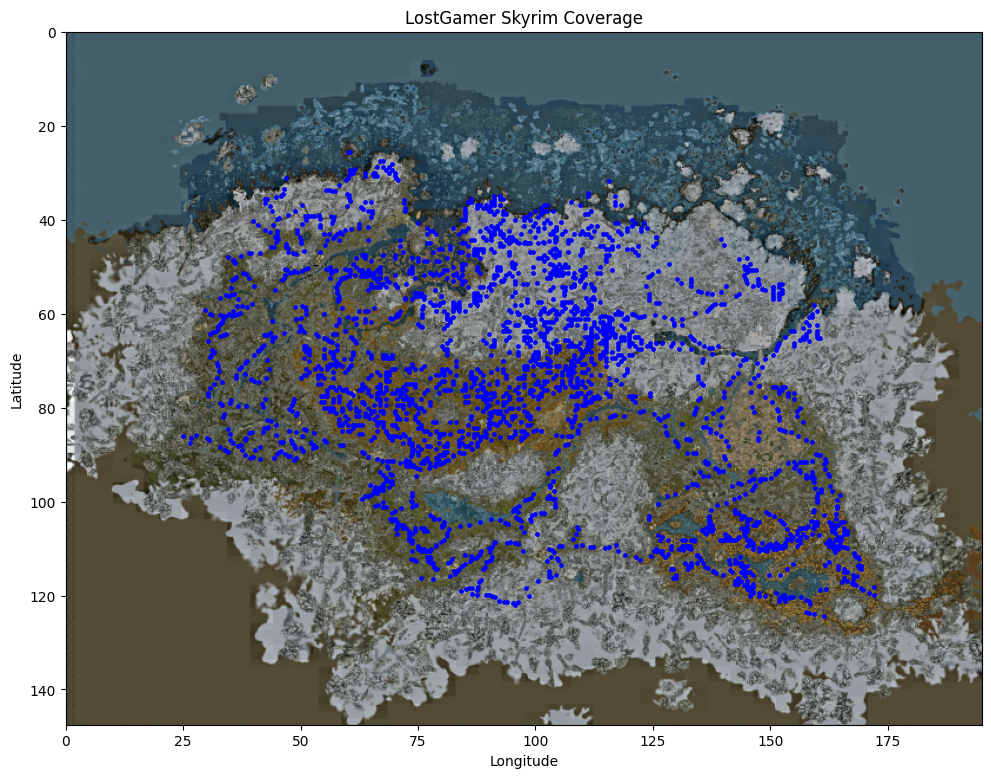

In [5]:
BACKGROUND_PLOT_IMAGE = plt.imread("../assets/skyrim_map_lostgamer.png")
LONGITUDE_MIN, LONGITUDE_MAX  = 0, 195
LATITUDE_MIN, LATITUDE_MAX = 0, 147.5

fig_coverage, ax_coverage = plt.subplots(figsize=(12, 9))

ax_coverage.imshow(BACKGROUND_PLOT_IMAGE, extent=[LONGITUDE_MIN, LONGITUDE_MAX, LATITUDE_MAX, LATITUDE_MIN])

plt.scatter(image_data.longitude, -1 * image_data.latitude, c="blue", label="True", s=6)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("LostGamer Skyrim Coverage")

plt.show()

In [7]:
TOTAL_SAMPLES = len(image_data)
TRAIN_LEN = int(0.75 * TOTAL_SAMPLES)
VAL_LEN = int(0.1 * TRAIN_LEN)
TEST_LEN = TOTAL_SAMPLES - TRAIN_LEN - VAL_LEN

print(f"Total Samples: {TOTAL_SAMPLES}\nTrain Samples: {TRAIN_LEN}\nValidation Samples: {VAL_LEN}\nTest Samples: {TEST_LEN}")

shuffled_data = image_data.sample(frac=1, random_state=42).reset_index(drop=True)

train_data = shuffled_data[:TRAIN_LEN]
val_data = shuffled_data[TRAIN_LEN:TRAIN_LEN+VAL_LEN]
test_data = shuffled_data[TRAIN_LEN+VAL_LEN:]

Total Samples: 2702
Train Samples: 2026
Validation Samples: 202
Test Samples: 474


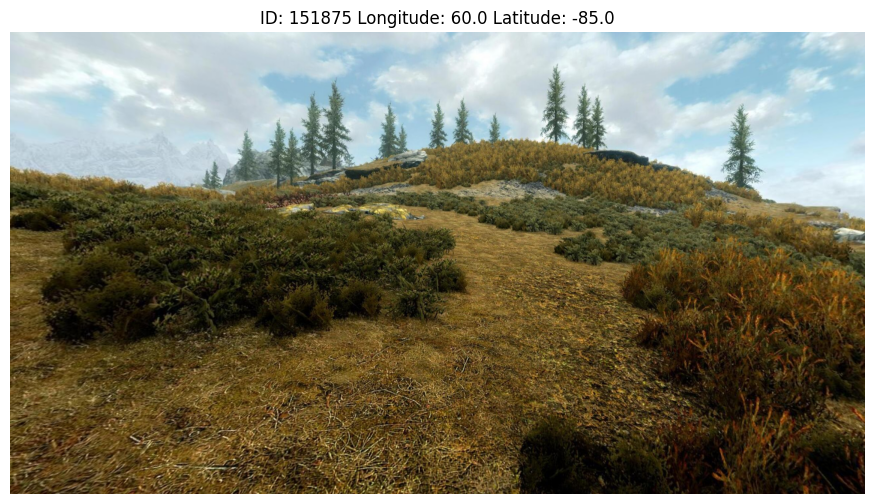

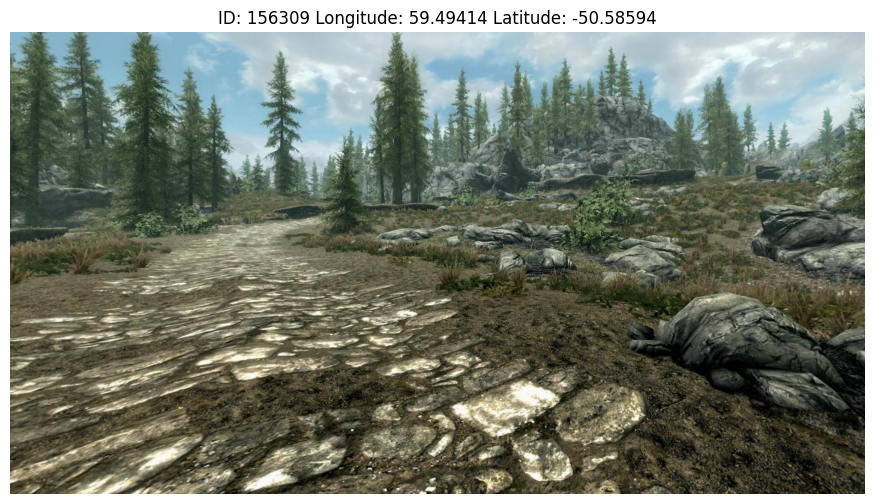

In [8]:
def show_random_samples(dataframe: pd.DataFrame, n: int) -> None:
    random_samples = dataframe.sample(n)

    for _, row in random_samples.iterrows():
        id, image_path, longitude, latitude = row
        image = cv2.imread(image_path)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(12, 6))
        plt.imshow(rgb_image)
        plt.title(f"ID: {id} Longitude: {longitude} Latitude: {latitude}")
        plt.axis("off")
        plt.show()
        
show_random_samples(image_data, 3)

In [9]:
train_transform = A.Compose([
    # A.RandomCrop(width=3080, height=770),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=10, p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.OneOf([
        A.ShiftScaleRotate(rotate_limit=10, scale_limit=0.05, shift_limit=0.05, p=0.33, border_mode=cv2.BORDER_CONSTANT),
        A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.33),
        A.Blur(blur_limit=3, p=0.33)
    ], p=1),
    A.Resize(width=1140, height=616),
    A.Normalize(mean=mean, std=std, max_pixel_value=255),
    ToTensorV2()
])

test_transform = A.Compose([
    # A.CenterCrop(width=3080, height=770),
    A.Resize(width=1140, height=616),
    A.Normalize(mean=mean, std=std, max_pixel_value=255),
    ToTensorV2()
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


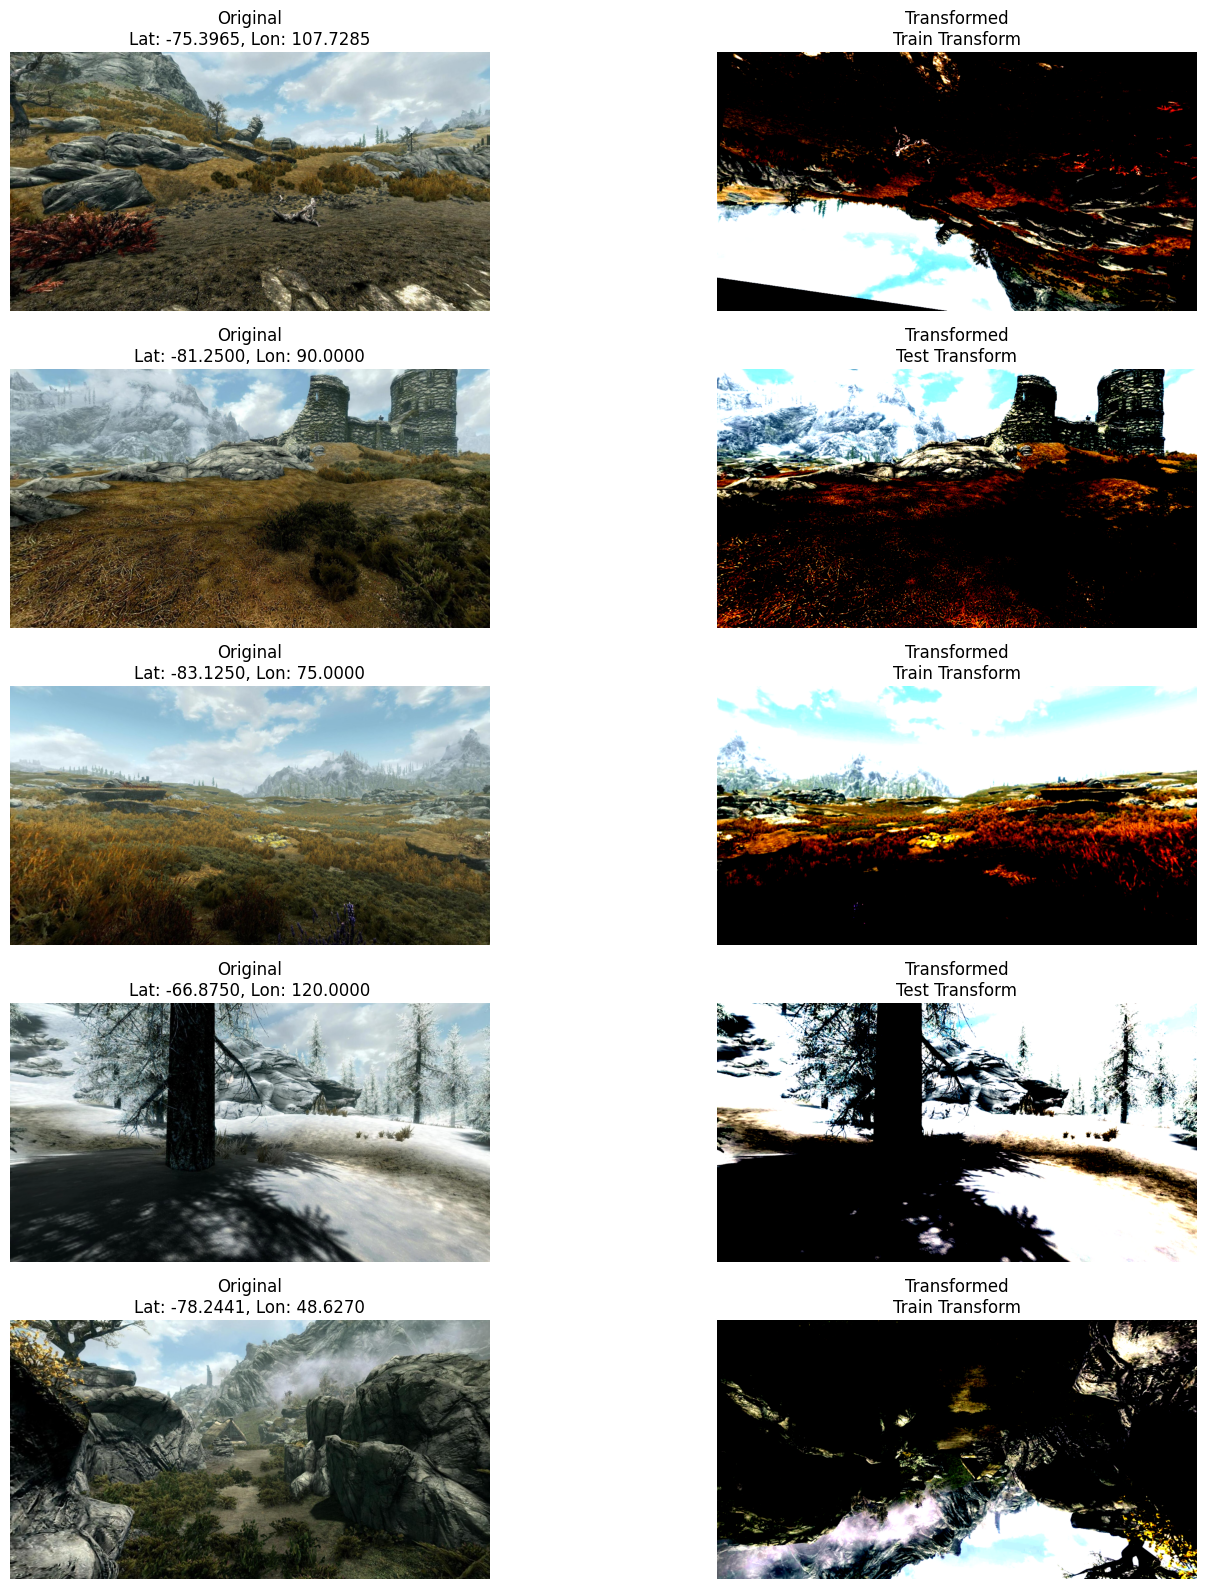

In [10]:
def apply_transforms_and_plot(dataframe: pd.DataFrame, train_transform, test_transform, n: int) -> None:
    random_samples = dataframe.sample(n)
    fig, axes = plt.subplots(n, 2, figsize=(16, 16))
    i = 0
    for _, row in random_samples.iterrows():
        _, image_path, longitude, latitude = row
        image = cv2.imread(image_path)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if i % 2 == 0:
            transformed = train_transform(image=rgb_image)
            transform_name = "Train Transform"
        else:
            transformed = test_transform(image=rgb_image)
            transform_name = "Test Transform"

        transformed_image = transformed["image"]
        transformed_image = np.transpose(transformed_image, (1, 2, 0))

        axes[i][0].imshow(rgb_image)
        axes[i][0].set_title(f"Original\nLat: {latitude:.4f}, Lon: {longitude:.4f}")
        axes[i][0].axis("off")

        axes[i][1].imshow(transformed_image, vmin=0, vmax=255)
        axes[i][1].set_title(f"Transformed\n{transform_name}")
        axes[i][1].axis("off")
        i += 1

    plt.tight_layout()
    plt.show()

apply_transforms_and_plot(image_data, train_transform, test_transform, n=5)

In [11]:
class SkyrimLocationsDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, is_train: bool, transform=None):
        self.input = dataframe
        self.is_train = is_train
        self.transform = transform

    def __len__(self) -> int:
        return len(self.input)

    def __getitem__(self, idx: int | torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.is_train:
            id, filepath, longitude, latitude = self.input.iloc[idx]
            target_tensor = torch.Tensor([longitude, latitude])
        else:
            id, filepath = self.input.iloc[idx]
            target_tensor =  torch.Tensor([1, 1])

        image = cv2.imread(filepath)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample = self.transform(image=rgb_image)["image"]
        return sample, target_tensor

In [12]:
BATCH_SIZE = 4

In [13]:
# dataset = SkyrimLocationsDataset(image_data, is_train=True, transform=test_transform)
# loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
#
# psum = torch.tensor([0, 0, 0])
# psum_sq = torch.tensor([0, 0, 0])
#
# # loop through images
# for inputs, _ in tqdm(loader):
#     psum += inputs.sum(axis=[0, 2, 3])
#     psum_sq += (inputs ** 2).sum(axis=[0, 2, 3])
#
# count = len(image_data) * 5130 * 770
#
# # mean and std
# total_mean = psum / count
# total_var = (psum_sq / count) - (total_mean ** 2)
# total_std = torch.sqrt(total_var)
#
# # output
# print("mean: " + str(total_mean))
# print("std: " + str(total_std))

In [18]:
train_dataset = SkyrimLocationsDataset(train_data, transform=test_transform, is_train=True)
val_dataset = SkyrimLocationsDataset(val_data, transform=test_transform, is_train=True)
test_dataset = SkyrimLocationsDataset(test_data, transform=test_transform, is_train=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
device

device(type='cuda')

In [20]:
LEARNING_RATE = 10 ** -3
NUM_EPOCHS = 50

In [21]:
model = resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
)
model.to(device)

criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

In [22]:
train_losses = np.array([])
val_losses = np.array([])
SAVE_MODEL_PATH = "../models/resnet50-v2.pth"
# inputs, coordinates = next(iter(train_loader))

for epoch in tqdm(range(NUM_EPOCHS)):
    model.train()
    running_loss = 0
    for inputs, coordinates in train_loader:
        inputs = inputs.to(device)
        coordinates = coordinates.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, coordinates)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses = np.append(train_losses, train_loss)

    model.eval()
    running_loss = 0
    with torch.no_grad():
        for inputs, coordinates in val_loader:
            inputs = inputs.to(device)
            coordinates = coordinates.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, coordinates)
            running_loss += loss.item()

    val_loss = running_loss / len(val_loader)
    if val_losses.size == 0 or np.min(val_losses) >= val_loss:
        torch.save(model.state_dict(), SAVE_MODEL_PATH)

    val_losses = np.append(val_losses, val_loss)

    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50: Train Loss: 1019.7392, Val Loss: 881.3796
Epoch 2/50: Train Loss: 779.8579, Val Loss: 689.5126
Epoch 3/50: Train Loss: 721.3041, Val Loss: 1343.7769
Epoch 4/50: Train Loss: 680.7717, Val Loss: 779.4311
Epoch 5/50: Train Loss: 669.2455, Val Loss: 1315.3556
Epoch 6/50: Train Loss: 656.6213, Val Loss: 649.7960
Epoch 7/50: Train Loss: 623.5920, Val Loss: 1212.6251
Epoch 8/50: Train Loss: 636.2943, Val Loss: 711.8390
Epoch 9/50: Train Loss: 623.2536, Val Loss: 637.9975
Epoch 10/50: Train Loss: 607.1791, Val Loss: 681.6178
Epoch 11/50: Train Loss: 613.1831, Val Loss: 835.1626
Epoch 12/50: Train Loss: 619.0870, Val Loss: 1272.4850
Epoch 13/50: Train Loss: 590.4067, Val Loss: 800.7888
Epoch 14/50: Train Loss: 585.3774, Val Loss: 623.9207
Epoch 15/50: Train Loss: 580.4325, Val Loss: 906.3124
Epoch 16/50: Train Loss: 558.2739, Val Loss: 635.1165
Epoch 17/50: Train Loss: 559.3759, Val Loss: 642.1570
Epoch 18/50: Train Loss: 581.0172, Val Loss: 761.6291
Epoch 19/50: Train Loss: 570.074

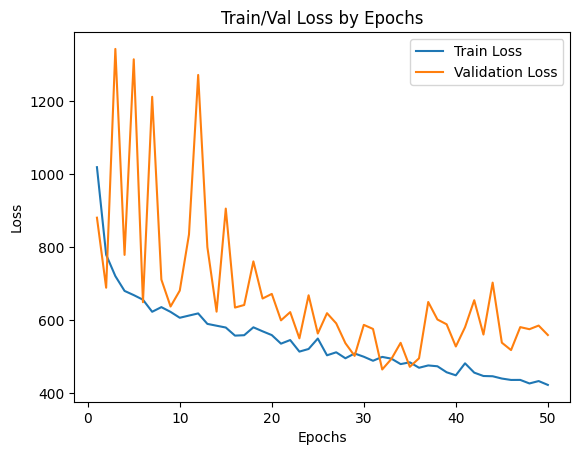

In [23]:
epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train/Val Loss by Epochs")
plt.legend()
plt.show()

In [24]:
LOAD_MODEL_PATH = "../models/resnet50-v2.pth"
model = resnet50()
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
)
model.to(device)
model.load_state_dict(torch.load(LOAD_MODEL_PATH))

test_loss = 0
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, coordinates in test_loader:
        inputs = inputs.to(device)
        coordinates = coordinates.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, coordinates)
        test_loss += loss.item()

        y_true.append(coordinates.cpu().numpy())
        y_pred.append(outputs.cpu().numpy())

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

Test Loss: 504.3126


In [25]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_true = y_true.reshape(y_true.shape[0], 2)
y_pred = y_pred.reshape(y_pred.shape[0], 2)

In [26]:
data = {
    "true_longitude": y_true[:, 0],
    "pred_longitude": y_pred[:, 0],
    "true_latitude": y_true[:, 1],
    "pred_latitude": y_pred[:, 1]
}

predicted_coordinates = pd.DataFrame(data)
predicted_coordinates

true_longitude  pred_longitude  true_latitude  pred_latitude
0         43.052731       96.554031     -84.212891     -97.978523
1        133.669922       82.528938     -81.304688     -76.778580
2         68.322273       78.049904     -53.078121     -74.587471
3         82.500000       81.159363     -53.125000     -69.063271
4         86.250000       77.364738     -44.375000     -56.569313
..              ...             ...            ...            ...
469       76.875000       79.836494     -45.000000     -56.936211
470       81.250000       73.715462     -76.250000     -78.153084
471      110.625000      102.453613     -51.875000     -48.310581
472       53.750000       72.775375     -71.250000     -72.567986
473       98.359383       82.167824     -99.470703     -81.165710

[474 rows x 4 columns]

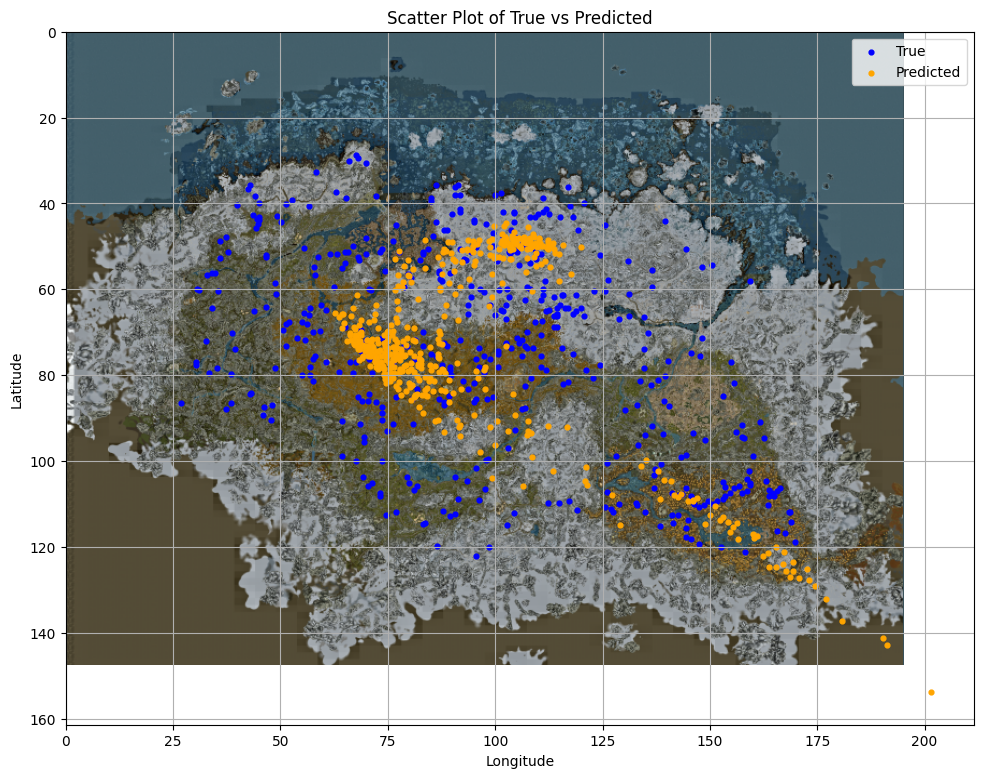

In [27]:
fig_test, ax_test = plt.subplots(figsize=(12, 9))
ax_test.imshow(BACKGROUND_PLOT_IMAGE, extent=[LONGITUDE_MIN, LONGITUDE_MAX, LATITUDE_MAX, LATITUDE_MIN])

plt.scatter(y_true[:, 0], -1 * y_true[:, 1], c="blue", label="True", s=12)
plt.scatter(y_pred[:, 0], -1 * y_pred[:, 1], c="orange", label="Predicted", s=12)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Scatter Plot of True vs Predicted")

plt.legend()
plt.grid(True)
plt.show()

In [28]:
def generate_heatmap(image_path, model, transform):
    image = cv2.imread(image_path)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    sample = transform(image=rgb_image)["image"]
    input_image = sample.unsqueeze(0)
    input_image = input_image.to(device)
    input_image.requires_grad = True

    output = model(input_image)

    model.zero_grad()
    output.backward(torch.ones_like(output))

    gradients = input_image.grad
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.conv1.weight.grad
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = torch.relu(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = heatmap.cpu().numpy()

    heatmap = cv2.resize(heatmap, (input_image.shape[3], input_image.shape[2]))
    heatmap = np.transpose(heatmap, (2, 0, 1))
    heatmap = np.mean(heatmap, axis=0)
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = heatmap.astype(np.float32) / 255
    heatmap = np.transpose(heatmap, (2, 0, 1))
    input_image = input_image.detach().cpu().numpy().squeeze()
    superimposed_image = cv2.addWeighted(input_image / 255.0, 0.5, heatmap, 0.5, 0)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(np.transpose(input_image, (1, 2, 0)))
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    axes[1].imshow(np.transpose(superimposed_image, (1, 2, 0)))
    axes[1].set_title("Heatmap")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

In [29]:
generate_heatmap(test_data.iloc[0].filepath, model, test_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
